In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import copy
import time
import os
import sys
sys.path.append('../../')

from data.processing import get_data

import models

from main.seir.fitting import single_fitting_cycle
from main.seir.forecast import get_forecast, forecast_all_trials, create_all_trials_csv, create_decile_csv_new
from main.seir.sensitivity import calculate_sensitivity_and_plot
from utils.generic.create_report import save_dict_and_create_report
from utils.generic.config import read_config
from utils.generic.enums import Columns
from utils.fitting.loss import Loss_Calculator
#from utils.generic.logging import log_wandb
from viz import plot_forecast, plot_top_k_trials, plot_ptiles, plot_ptiles_comp
from viz.fit import plot_all_losses

import yaml

In [3]:
from os.path import exists, join, splitext

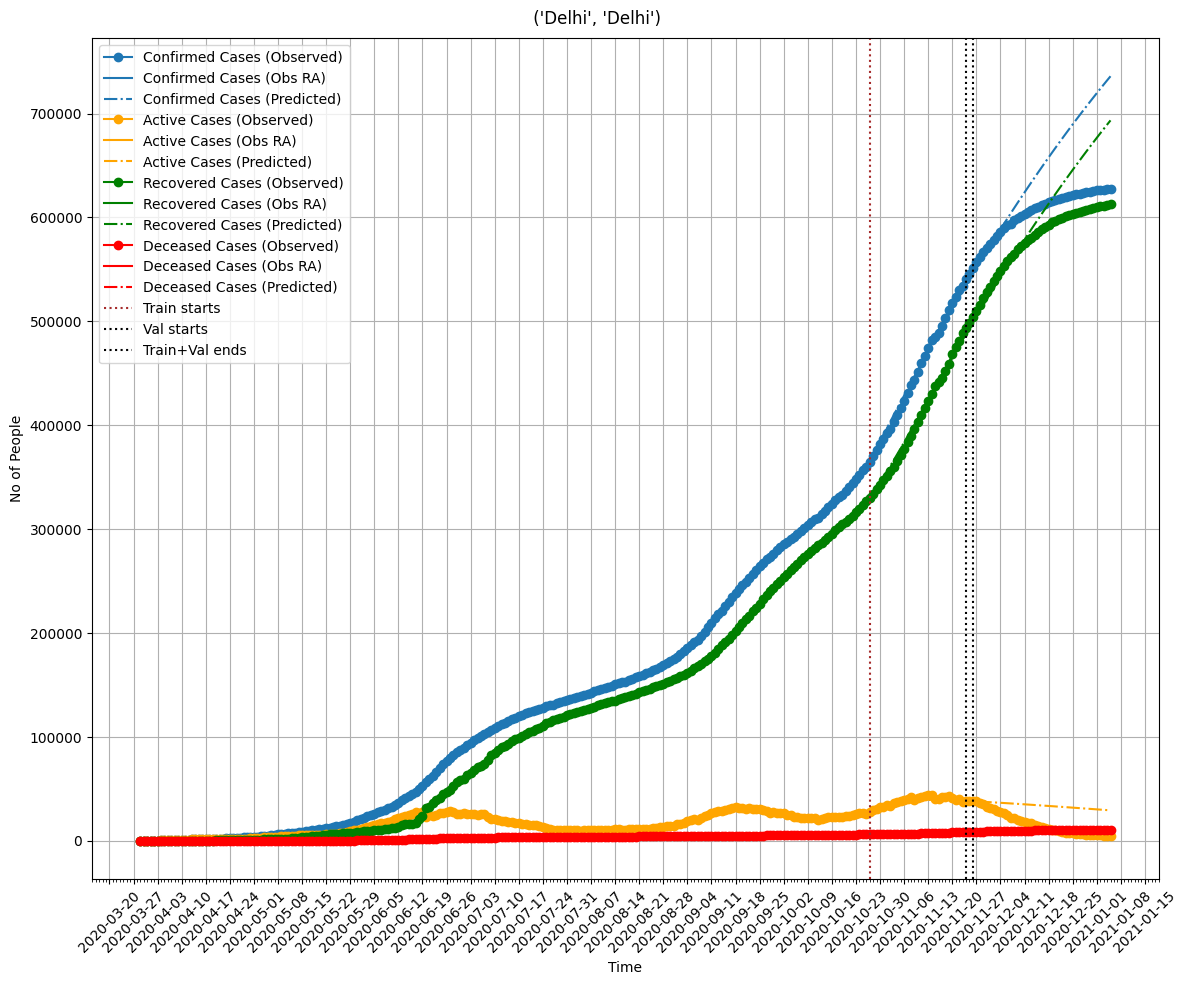

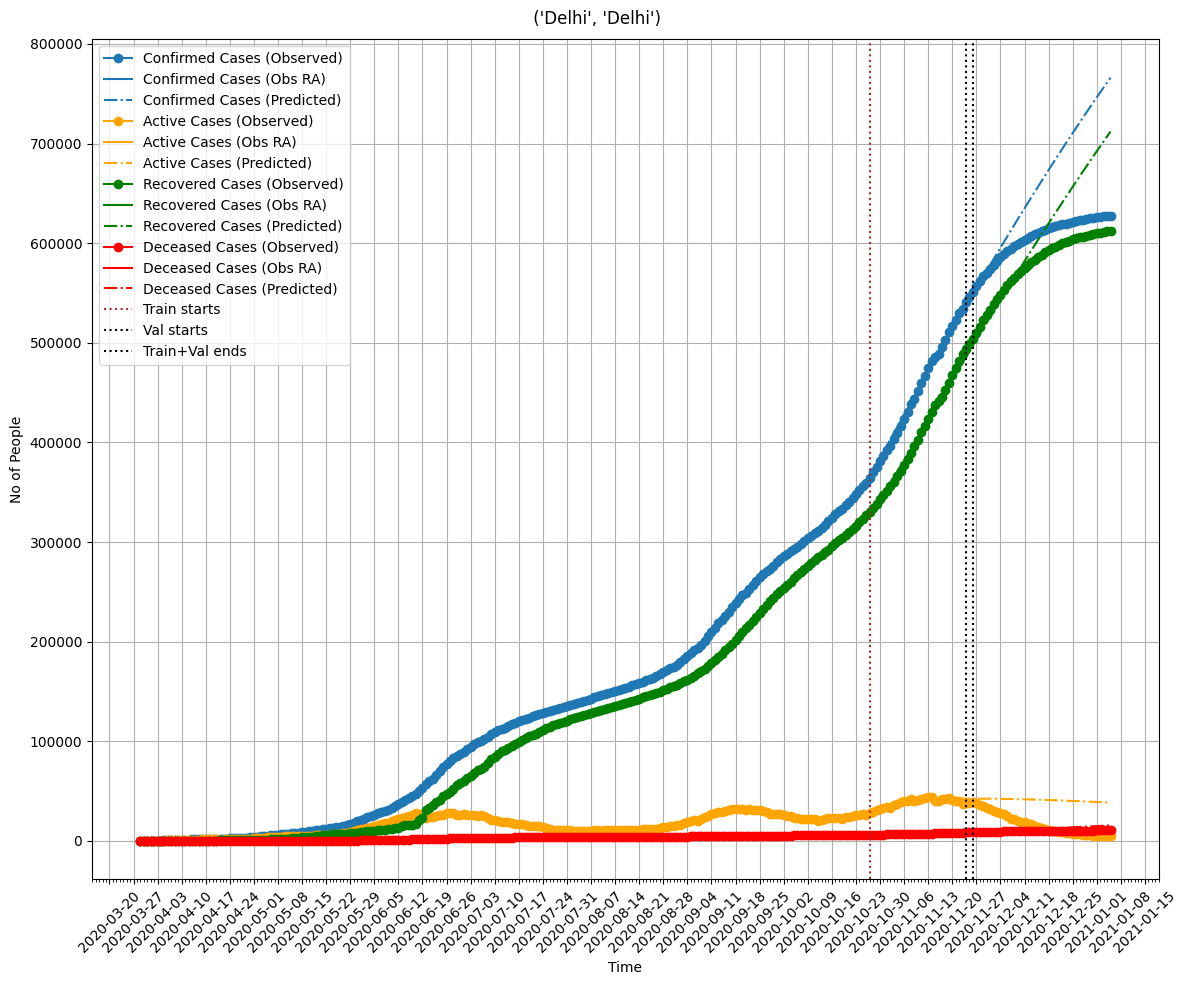

In [4]:
import pickle as pkl
with open('../../misc/predictions/test_mumbai.pickle', 'rb') as handle:
    PD = pkl.load(handle)

In [5]:
PD['m0']['MCMC']['m1'].keys()

dict_keys(['plots', 'best_params', 'default_params', 'variable_param_ranges', 'optimiser', 'df_prediction', 'df_district', 'df_train', 'df_val', 'df_test', 'df_loss', 'trials', 'data_last_date', 'metric', 'smoothing_description', 'df_district_unsmoothed', 'run_params', 'forecasts', 'trials_processed'])

In [6]:
config_filename = 'default.yaml'
config = read_config(config_filename)

In [7]:
config['forecast']['plot_ptiles_for_columns']

[<Columns.total: Column(name='total', label='Confirmed Cases', color='C0')>]

In [8]:
PD['m0']['MCMC'].keys()

dict_keys(['m1', 'uncertainty_forecasts', 'ensemble_mean_forecast'])

{<Columns.total: Column(name='total', label='Confirmed Cases', color='C0')>: <Figure size 864x864 with 1 Axes>}

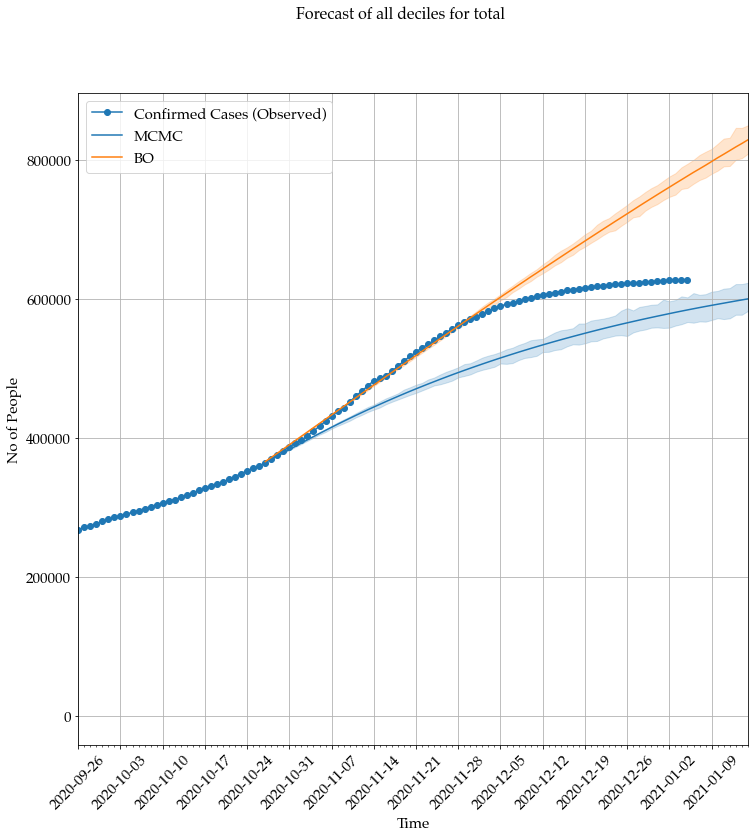

In [31]:
plot_ptiles_comp(PD['m0'], which_compartments=config['forecast']['plot_ptiles_for_columns'])

In [10]:
import matplotlib as mpl
## for Palatino and other serif fonts use:
plt.rcParams.update({
    'font.size': 15,
    'font.family': 'Palatino',
 })

In [11]:
import pandas as pd
PD['m0']['MCMC']['ensemble_mean_forecast']['df_loss']

{'active': 46.85574043999188,
 'recovered': 14.307369334269762,
 'deceased': 2.992944154711825,
 'total': 12.078568605022879}

In [12]:
which_compartments = ['total', 'active', 'recovered', 'deceased','agg']

In [25]:
df_compiled = {"MCMC":[],"BO":[]}
for run,run_dict in PD.items():
    for model,model_dict in run_dict.items():
        df = model_dict['m1']['df_loss']['train']
        df['agg'] = df.mean()
        df_compiled[model].append(df)
        

In [26]:
np.linspace(0,100,42)

array([  0.        ,   2.43902439,   4.87804878,   7.31707317,
         9.75609756,  12.19512195,  14.63414634,  17.07317073,
        19.51219512,  21.95121951,  24.3902439 ,  26.82926829,
        29.26829268,  31.70731707,  34.14634146,  36.58536585,
        39.02439024,  41.46341463,  43.90243902,  46.34146341,
        48.7804878 ,  51.2195122 ,  53.65853659,  56.09756098,
        58.53658537,  60.97560976,  63.41463415,  65.85365854,
        68.29268293,  70.73170732,  73.17073171,  75.6097561 ,
        78.04878049,  80.48780488,  82.92682927,  85.36585366,
        87.80487805,  90.24390244,  92.68292683,  95.12195122,
        97.56097561, 100.        ])

In [27]:
df_compiled['MCMC'][0]

total        0.840568
active        4.62719
recovered    0.835125
deceased      1.36407
agg           1.91674
Name: train, dtype: object

In [28]:
import pandas as pd
stats = {}
stats['MCMC'] = (pd.DataFrame(df_compiled['MCMC']).describe()).loc[['mean','std']]
stats['BO'] = (pd.DataFrame(df_compiled['BO']).describe()).loc[['mean','std']]

In [29]:
stats['BO'].loc[['mean']]

,total,active,recovered,deceased,agg
mean,0.743299,3.889108,0.775564,0.883458,1.572857


## Comparing best loss from MCMC vs BO

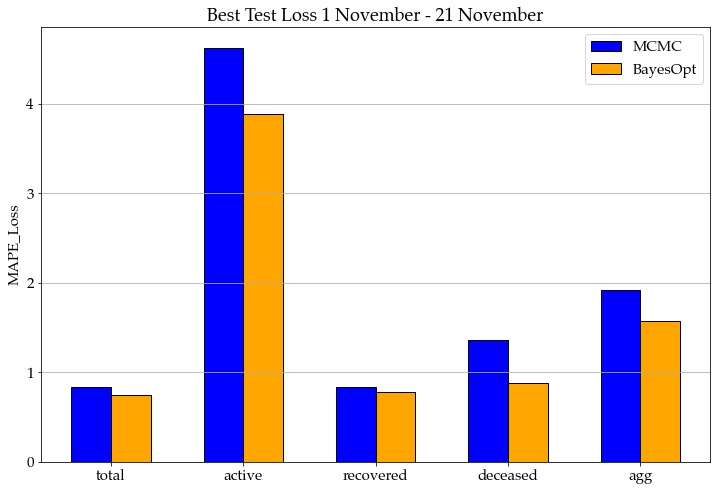

In [30]:
import numpy as np
import matplotlib.pyplot as plt
barWidth = 0.3

plt.figure(figsize=(12,8))
# Choose the height of the blue bars
bars1 = stats['MCMC'].loc[['mean']].values[0]
 
# Choose the height of the cyan bars
bars2 = stats['BO'].loc[['mean']].values[0]
 
# Choose the height of the error bars (bars1)
yer1 = stats['MCMC'].loc[['std']].values[0]
 
# Choose the height of the error bars (bars2)
yer2 = stats['BO'].loc[['std']].values[0]
 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='MCMC')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = 'orange', edgecolor = 'black', yerr=yer2, capsize=7, label='BayesOpt')
 
# general layout
plt.grid(b = True,axis = 'y')
plt.xticks([r + barWidth/2 for r in range(len(bars1))], which_compartments)
plt.ylabel('MAPE_Loss')
plt.title('Best Test Loss 1 November - 21 November')
plt.legend()
 
# Show graphic
plt.show()


## Comparing Ensemble loss from MCMC vs BO

In [32]:
PD['m0']['MCMC']['ensemble_mean_forecast']['df_loss']

{'active': 46.85574043999188,
 'recovered': 14.307369334269762,
 'deceased': 2.992944154711825,
 'total': 12.078568605022879,
 'agg': 19.058655633499086}

In [33]:
df_compiled_ens = {"MCMC":[],"BO":[]}
for run,run_dict in PD.items():
    for model,model_dict in run_dict.items():
        df = model_dict['ensemble_mean_forecast']['df_loss']
        df['agg'] = np.mean(list(df.values()))
        df2 = {comp:df[comp] for comp in which_compartments}
        df_compiled_ens[model].append(df2)

In [34]:
import pandas as pd
stats_ens = {}
stats_ens['MCMC'] = (pd.DataFrame(df_compiled_ens['MCMC']).describe()).loc[['mean','std']]
stats_ens['BO'] = (pd.DataFrame(df_compiled_ens['BO']).describe()).loc[['mean','std']]

In [35]:
pd.DataFrame(df_compiled_ens['MCMC'])

,total,active,recovered,deceased,agg
0,12.078569,46.85574,14.307369,2.992944,19.058656


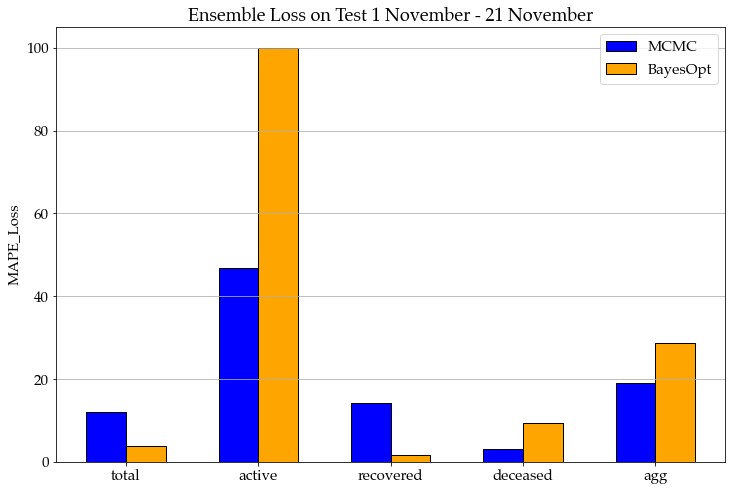

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
barWidth = 0.3

plt.figure(figsize=(12,8))
# Choose the height of the blue bars
bars1 = stats_ens['MCMC'].loc[['mean']].values[0]
 
# Choose the height of the cyan bars
bars2 = stats_ens['BO'].loc[['mean']].values[0]
 
# Choose the height of the error bars (bars1)
yer1 = stats_ens['MCMC'].loc[['std']].values[0]
 
# Choose the height of the error bars (bars2)
yer2 = stats_ens['BO'].loc[['std']].values[0]
 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='MCMC')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = 'orange', edgecolor = 'black', yerr=yer2, capsize=7, label='BayesOpt')
 
# general layout
plt.grid(b = True,axis = 'y')
plt.xticks([r + barWidth/2 for r in range(len(bars1))], which_compartments)
plt.ylabel('MAPE_Loss')
plt.title('Ensemble Loss on Test 1 November - 21 November')
plt.legend()
 
# Show graphic
plt.show()

## DIC 

In [ ]:
df_compiled_DIC = {"MCMC":[],"BO":[]}
for run,run_dict in PD.items():
    for model,model_dict in run_dict.items():
        df = model_dict['m1']['metric']['DIC']
        df_compiled_DIC[model].append(df)
df_compiled_DIC

In [32]:
barWidth = 0.3
plt.figure(figsize=(10,13))
# Choose the height of the blue bars
bars1 = [np.mean(df_compiled_DIC['MCMC'])]
 
# Choose the height of the cyan bars
bars2 = [np.mean(df_compiled_DIC['BO'])]
 
# Choose the height of the error bars (bars1)
yer1 = [np.std(df_compiled_DIC['MCMC'])]
 
# Choose the height of the error bars (bars2)
yer2 = [np.std(df_compiled_DIC['BO'])]
 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='MCMC')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = 'orange', edgecolor = 'black', yerr=yer2, capsize=7, label='BayesOpt')
 
# general layout
plt.grid(b = True,axis = 'y')
plt.xticks([r + barWidth/2 for r in range(len(bars1))], ['MCMC                                    BO'])
plt.ylabel('DIC')
plt.title('DIC Values on Train for 25 Aug to 16 Sep')
plt.legend()
 
# Show graphic
plt.show()

NameError: name 'df_compiled_DIC' is not defined

## Percentile Loss

In [33]:
PD['m0']['MCMC']['uncertainty_forecasts'].keys()

dict_keys([2.43902439, 4.87804878, 7.31707317, 9.75609756, 12.19512195, 14.63414634, 17.07317073, 19.51219512, 21.95121951, 24.3902439, 26.82926829, 29.26829268, 31.70731707, 34.14634146, 36.58536585, 39.02439024, 41.46341463, 43.90243902, 46.34146341, 48.7804878, 51.2195122, 53.65853659, 56.09756098, 58.53658537, 60.97560976, 63.41463415, 65.85365854, 68.29268293, 70.73170732, 73.17073171, 75.6097561, 78.04878049, 80.48780488, 82.92682927, 85.36585366, 87.80487805, 90.24390244, 92.68292683, 95.12195122, 97.56097561])

In [40]:
df_compiled_perc_loss = {"MCMC":[],"BO":[]}
percentiles = []

for run,run_dict in PD.items():
    for model,model_dict in run_dict.items():
        df = {}
        percentiles = list(model_dict['uncertainty_forecasts'].keys())
        for perc,perc_dict in model_dict['uncertainty_forecasts'].items():
            df[perc] = perc_dict['df_loss_perc']['test']['total']
        df_compiled_perc_loss[model].append(df)

In [41]:
pd.DataFrame(df_compiled_perc_loss['MCMC'])

,2.439024,4.878049,7.317073,9.756098,12.195122,14.634146,17.073171,19.512195,21.951220,24.390244,...,75.609756,78.048780,80.487805,82.926829,85.365854,87.804878,90.243902,92.682927,95.121951,97.560976
0,0.468799,0.874946,1.266115,1.640504,1.996477,2.32917,2.656921,2.978667,3.277592,3.582999,...,7.214795,7.276117,7.26276,7.235517,7.111218,6.943952,6.751329,6.231021,5.377,4.309186


In [42]:
stats_perc_MCMC = pd.DataFrame(df_compiled_perc_loss['MCMC']).describe().loc[['mean','std']]
stats_perc_BO = pd.DataFrame(df_compiled_perc_loss['BO']).describe().loc[['mean','std']]

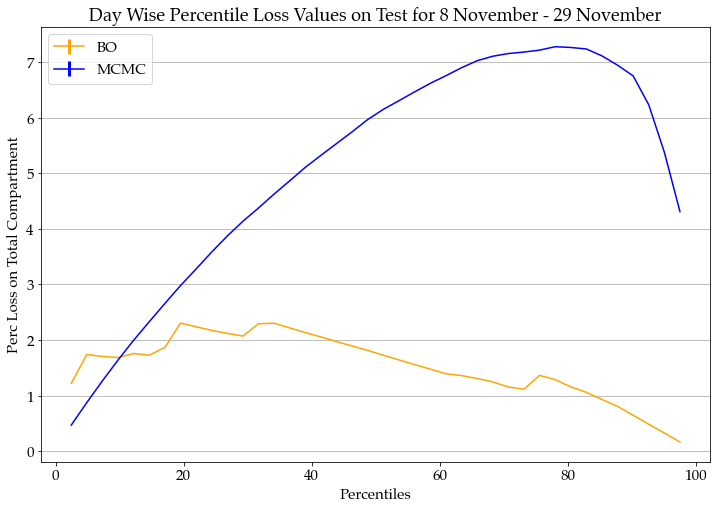

In [43]:
import matplotlib as mpl
barWidth = 0.3

plt.figure(figsize=(12,8))
plt.errorbar(list(stats_perc_BO.loc['mean'].keys()),list(stats_perc_BO.loc['mean'].values),color = 'orange',label='BO',yerr =list(stats_perc_BO.loc['std'].values) ,elinewidth =3,capthick =3,barsabove = True)
plt.errorbar(list(stats_perc_MCMC.loc['mean'].keys()),list(stats_perc_MCMC.loc['mean'].values),color = 'blue',label = 'MCMC',yerr = list(stats_perc_MCMC.loc['std'].values),elinewidth =3,capthick =3,barsabove = True)


# general layout
plt.grid(b = True,axis = 'y')
plt.ylabel('Perc Loss on Total Compartment')
plt.xlabel('Percentiles')
plt.title('Day Wise Percentile Loss Values on Test for 8 November - 29 November')
plt.legend()
 
# Show graphic
plt.show()

In [44]:
from viz.fit import plot_comp_density_plots,plot_histogram

(<Figure size 864x1224 with 8 Axes>,
 array([[<AxesSubplot:title={'center':'Denisty Plot of parameter E_hosp_ratio'}, ylabel='Density'>,
         <AxesSubplot:title={'center':'Denisty Plot of parameter I_hosp_ratio'}, ylabel='Density'>],
        [<AxesSubplot:title={'center':'Denisty Plot of parameter P_fatal'}, ylabel='Density'>,
         <AxesSubplot:title={'center':'Denisty Plot of parameter T_inc'}, ylabel='Density'>],
        [<AxesSubplot:title={'center':'Denisty Plot of parameter T_inf'}, ylabel='Density'>,
         <AxesSubplot:title={'center':'Denisty Plot of parameter T_recov'}, ylabel='Density'>],
        [<AxesSubplot:title={'center':'Denisty Plot of parameter T_Death'}, ylabel='Density'>,
         <AxesSubplot:title={'center':'Denisty Plot of parameter lockdown_R0'}, ylabel='Density'>]],
       dtype=object))

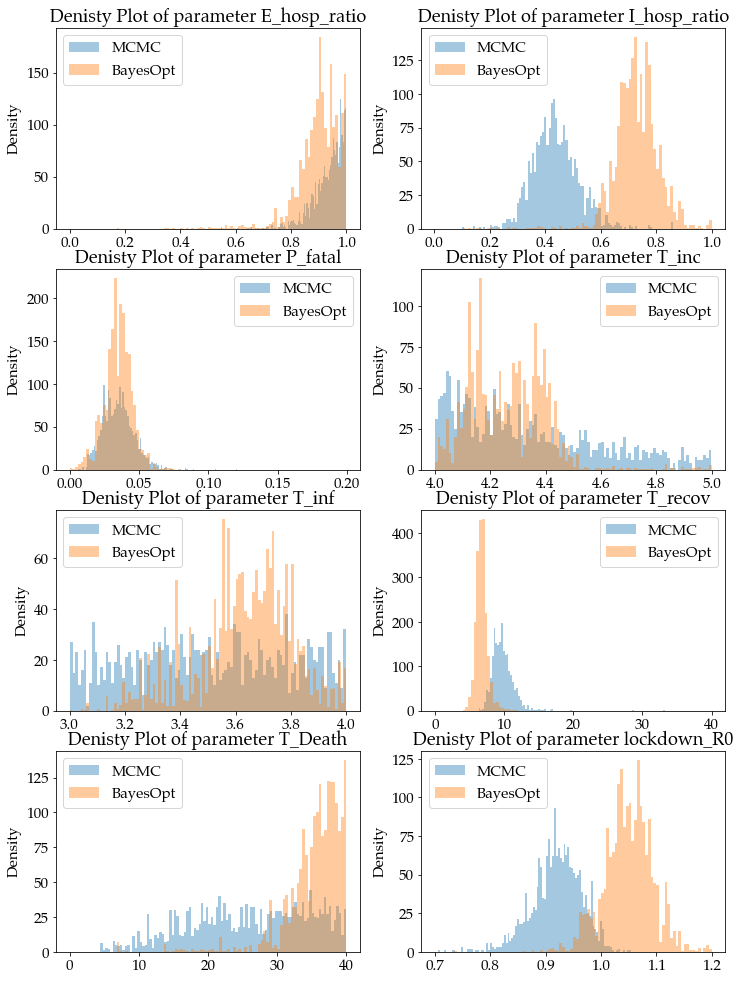

In [45]:
figs, axs = plt.subplots(4,2,figsize = [12,17])
plot_comp_density_plots(PD,figs,axs)
